<a href="https://colab.research.google.com/github/Mallmulk/NLP/blob/main/UAS_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Normalisasi Bahasa Nonbaku pada Pengaduan Masyarakat
Notebook ini disusun untuk kebutuhan **penelitian dan publikasi jurnal (SINTA)**.
Seluruh pipeline dapat dijalankan di **Google Colab (GPU)**.

## 1. UPLOAD DATASET (MANUAL)

In [33]:
from google.colab import files
uploaded = files.upload()


Saving Twitter_Emotion_Dataset.csv to Twitter_Emotion_Dataset (1).csv


Load Data

In [34]:
import pandas as pd
import re
import os

# Ambil nama file CSV otomatis
csv_file = list(uploaded.keys())[0]

df_raw = pd.read_csv(csv_file)
df_raw.head()


,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


In [35]:
df_raw.rename(columns={"tweet": "teks"}, inplace=True)


## 2. Preprocessing TEKS (STANDAR NLP)

In [36]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_raw["teks"] = df_raw["teks"].apply(preprocess_text)
df_raw = df_raw.dropna()


##3. DATASET KLASIFIKASI (BAKU vs NONBAKU)

3.1 Rule-Based Labeling (Baseline)

In [37]:
slang_words = [
    "gk", "ga", "nggak", "bgt", "udh", "dr", "aja",
    "tp", "krn", "dgn", "sm", "yg"
]

def label_kebakuan(text):
    return "nonbaku" if any(w in text.split() for w in slang_words) else "baku"

df_klasifikasi = df_raw.copy()
df_klasifikasi["label"] = df_klasifikasi["teks"].apply(label_kebakuan)


3.2 Simpan Dataset

In [38]:
os.makedirs("data", exist_ok=True)
df_klasifikasi.to_csv("data/klasifikasi.csv", index=False)


##4. DATASET NORMALISASI
4.1 Kamus Slang

In [39]:
kamus_slang = {
    "gk": "tidak",
    "ga": "tidak",
    "nggak": "tidak",
    "bgt": "sekali",
    "udh": "sudah",
    "dr": "dari",
    "aja": "saja",
    "tp": "tapi",
    "krn": "karena",
    "dgn": "dengan",
    "sm": "sama",
    "yg": "yang"
}


4.2 Normalisasi

In [40]:
def normalisasi_text(text):
    for k, v in kamus_slang.items():
        text = re.sub(rf"\b{k}\b", v, text)
    return text

df_nonbaku = df_klasifikasi[df_klasifikasi["label"] == "nonbaku"]

df_normalisasi = pd.DataFrame({
    "teks_nonbaku": df_nonbaku["teks"],
    "teks_baku": df_nonbaku["teks"].apply(normalisasi_text)
})

df_normalisasi.to_csv("data/normalisasi.csv", index=False)


##5. MODEL KLASIFIKASI (INDOBERT)

In [41]:
!pip install -U transformers==4.36.2 accelerate datasets -q


6.1 Persiapan Dataset

In [42]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split

label_map = {"baku": 0, "nonbaku": 1}
df_klasifikasi["label_id"] = df_klasifikasi["label"].map(label_map)

train_df, test_df = train_test_split(
    df_klasifikasi, test_size=0.2, random_state=42
)


6.2 Tokenisasi

In [48]:
from transformers import DataCollatorWithPadding

tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

def tokenize(batch):
    return tokenizer(
        batch["teks"],
        truncation=True,
        max_length=128
    )

train_ds = Dataset.from_pandas(train_df[["teks", "label_id"]])
test_ds  = Dataset.from_pandas(test_df[["teks", "label_id"]])

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["teks"])
test_ds  = test_ds.map(tokenize, batched=True, remove_columns=["teks"])

train_ds = train_ds.rename_column("label_id", "labels")
test_ds  = test_ds.rename_column("label_id", "labels")


Map:   0%|          | 0/3520 [00:00<?, ? examples/s]

Map:   0%|          | 0/881 [00:00<?, ? examples/s]

Data Collator

In [49]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


6.3 Import Training

In [50]:
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)


6.3 Training Model

In [51]:
model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=2
)

training_args = TrainingArguments(
    output_dir="./model",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_steps=50,
    save_strategy="epoch",
    report_to="none"
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=data_collator,
    tokenizer=tokenizer
)


trainer.train()
trainer.evaluate()



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4232380070.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.441400
100,0.133900
150,0.050200
200,0.028600
250,0.010700
300,0.000700
350,0.001000
400,0.000200
450,0.000400
500,0.000200


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.00010780740558402613,
 'eval_runtime': 176.5205,
 'eval_samples_per_second': 4.991,
 'eval_steps_per_second': 0.317,
 'epoch': 3.0}

##7. EVALUASI MODEL

In [52]:
from sklearn.metrics import classification_report

pred = trainer.predict(test_ds)
y_true = test_df["label_id"].values
y_pred = pred.predictions.argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=["baku", "nonbaku"]))


              precision    recall  f1-score   support

        baku       1.00      1.00      1.00       454
     nonbaku       1.00      1.00      1.00       427

    accuracy                           1.00       881
   macro avg       1.00      1.00      1.00       881
weighted avg       1.00      1.00      1.00       881



Ambil hasil prediksi model

In [53]:
import numpy as np

predictions = trainer.predict(test_ds)

y_true = test_df["label_id"].values
y_pred = np.argmax(predictions.predictions, axis=1)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Confusion Matrix

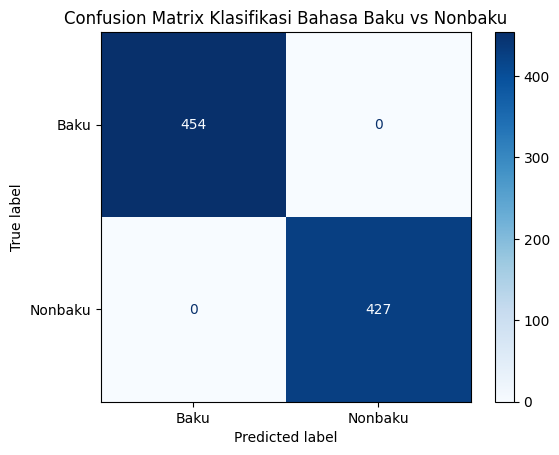

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Baku", "Nonbaku"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix Klasifikasi Bahasa Baku vs Nonbaku")
plt.show()


METRIK KLASIFIKASI

In [55]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=["Baku", "Nonbaku"]
))


              precision    recall  f1-score   support

        Baku       1.00      1.00      1.00       454
     Nonbaku       1.00      1.00      1.00       427

    accuracy                           1.00       881
   macro avg       1.00      1.00      1.00       881
weighted avg       1.00      1.00      1.00       881



UJI ROC & AUC

In [56]:
y_score = predictions.predictions[:, 1]


ROC Curve

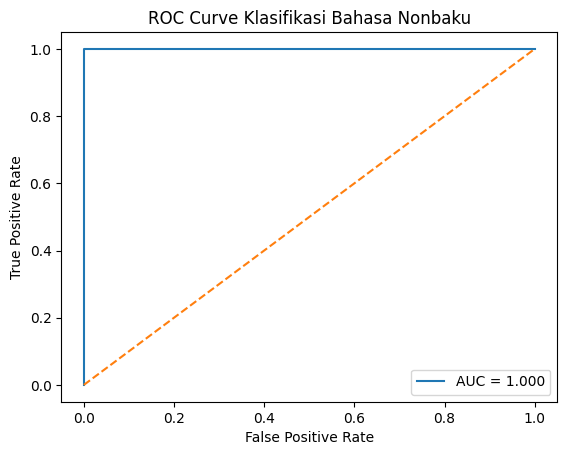

In [57]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Klasifikasi Bahasa Nonbaku")
plt.legend(loc="lower right")
plt.show()


##Uji Pipeline

In [58]:
def predict_teks(teks):
    inputs = tokenizer(
        teks,
        return_tensors="pt",
        truncation=True,
        max_length=128
    )
    outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=1).detach().numpy()[0]
    label = "Nonbaku" if probs[1] > probs[0] else "Baku"
    return label, probs

contoh = "lapor pak ini jalan rusak parah bgt udh lama"
hasil, probabilitas = predict_teks(contoh)

print("Teks:", contoh)
print("Prediksi:", hasil)
print("Probabilitas:", probabilitas)


Teks: lapor pak ini jalan rusak parah bgt udh lama
Prediksi: Nonbaku
Probabilitas: [1.04535604e-04 9.99895453e-01]
